# drosophila_simulation_analysis

> copy of notebook `04_drosophila_simulation`, for experimentation and analysis

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.phase_analysis as ana

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
print(jax.lib.xla_bridge.get_backend().platform)

cpu


In [ ]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs)

<module 'CE_simulation.drosophila' from '/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/drosophila.py'>

In [ ]:
## how to use default-dict

from collections import defaultdict

normal_dict = {"a": 1, "b": 2, "c": 3}
default_factory = lambda: (lambda x: 1)

dict_with_default_val = defaultdict(default_factory)
for key, val in normal_dict.items():
    dict_with_default_val[key] = val
    
dict_with_default_val["b"], dict_with_default_val["z"]

(2, <function __main__.<lambda>.<locals>.<lambda>(x)>)

## Initial condition creation

In notebook `02_delaunay_simulation` we have already seen how to create some initial conditions, based on triangular lattice patches. However, in the simulations we wish to carry out, we need to specify some more data:

- Boundary conditions
- Active and passive regions
- Plotting helpers, e.g. initial row of each cell

We present and additional routine for initial condition creation, more specific to the _Drosophila_ germ band simulations we plan to carry out.  

### Plot initial condition

In [ ]:
# create initial condition

mesh_initial, property_dict = drs.create_rect_initial(24, 34, noise=0.1, initial_strain=0.125, # 12, 18, 0.125
                                                      orientation='orthogonal', isogonal=0,
                                                      boundaries=['top', 'bottom',], #'left', 'right'
                                                      w_passive=0, w_passive_lr=.5, random_seed=0) # 6

# w passive 2 is too low for siure

In [ ]:
# set colors for edges and cells

edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5

cell_colors = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
               for key in mesh_initial.vertices.keys()
               if not key in property_dict['passive_cells']}

(-10.5, 10.5, -16.5, 16.5)

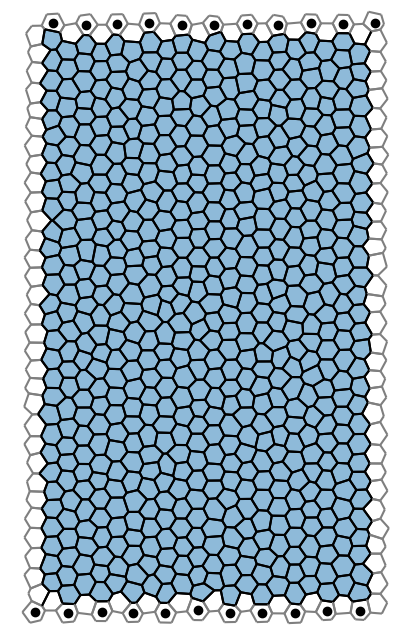

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    #plt.hlines((bdry_y-.25, -bdry_y+.25), (-9, -9), (9, 9), color="k")
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

plt.axis("off")

#plt.savefig("plots/initial_cond.pdf")

### Loading a saved simulation

In [ ]:
from joblib import Parallel, delayed

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band'

save_dir = f'{base_dir}/germ_band_new_post_T1_WT_new_passive/w_passive_7_randomSeed_3' # 2 looks good
#meshes_loaded = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh', )
#                 for i in tqdm(range(0, 300, 1))]

load_mesh = lambda i: iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh')
meshes_loaded = Parallel(n_jobs=48)(delayed(load_mesh)(i) for i in range(0, 250, 1))

In [ ]:
with open(f"{save_dir}/property_dict.pickle", "rb") as f:
    property_dict_loaded = pickle.load(f)
    
with open(f"{save_dir}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_edges = pickle.load(f)

In [ ]:
time = np.arange(len(meshes_loaded)) * 0.005 * 25

In [ ]:
bdry_x, bdry_y =(property_dict_loaded["bdry_x"], property_dict_loaded["bdry_y"]) 
cell_colors = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
               for key in meshes_loaded[0].vertices.keys()
               if not key in property_dict_loaded['passive_cells']}

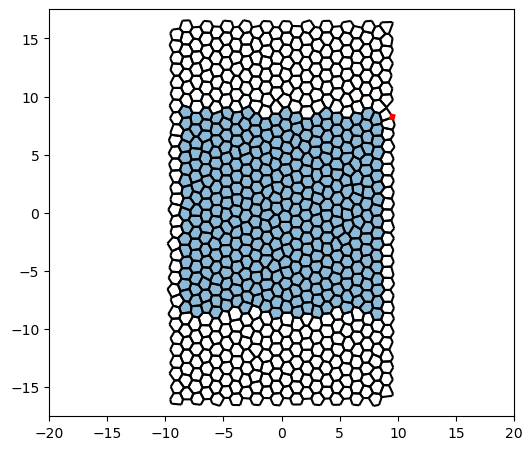

In [ ]:
fig = plt.figure(figsize=(6, 6))

drs.plot_mesh(1, 2*bdry_x, bdry_y+1.5, meshes_loaded, last_flipped_edges, cell_colors=cell_colors)

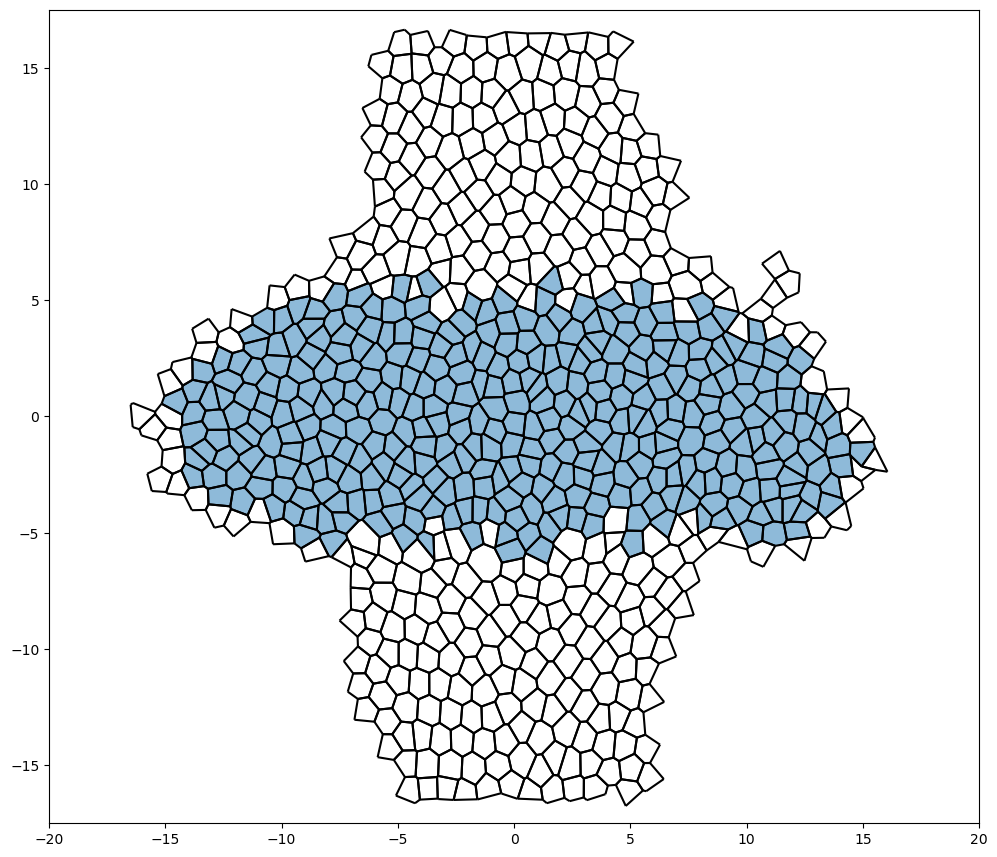

In [ ]:
fig = plt.figure(figsize=(12, 12))

drs.plot_mesh(249, 2*bdry_x, bdry_y+1.5, meshes_loaded, last_flipped_edges, cell_colors=cell_colors)

## Make plots for the paper

In [ ]:
edge_colors = {key: "silver" for key in property_dict_loaded['passive_edges']}

edge_colors_tri = {key: np.array([0.8, 0.2, 0, .2]) if key in property_dict_loaded['passive_edges']
                   or any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                   for key, he in meshes_loaded[0].hes.items()}

cell_colors = {key: "#eebbaaff" for key in meshes_loaded[0].vertices.keys()
                    if not key in property_dict_loaded['passive_cells']}


(-20.5, 20.5, -17.0, 17.0)

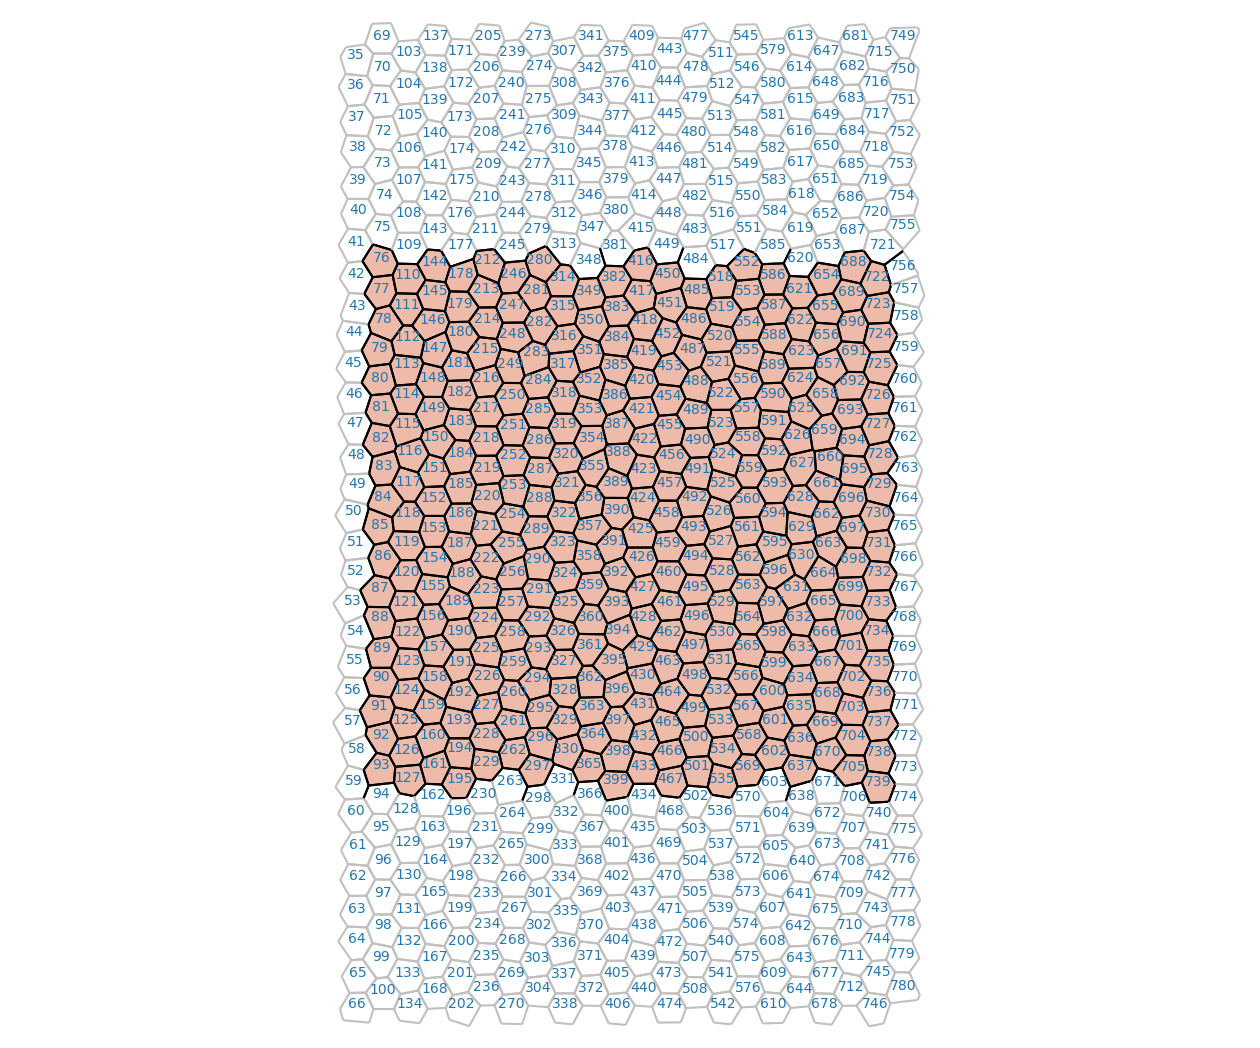

In [ ]:
# add line to visualize the slip boundary

fig = plt.figure(figsize=(16,16)) # 8,8

t = 1

meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

meshes_loaded[1].labelplot(vertex_labels=False, face_labels=False, halfedge_labels=False, cell_labels=True)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
if meshes_loaded[1].bdry_list:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=2)

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/germ_band_initial_cond_cells.pdf")

In [ ]:
bdry_lst = [69, 137, 205, 273, 341, 409, 477, 545, 613, 681, 749,
            66, 134, 202, 270, 338, 406, 474, 542, 610, 678, 746]

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2/fig_7_germ_band"

In [ ]:
## indicate some cells in the active and passive regions

In [ ]:
active = [[351, 352, 353], [384, 385, 386], [419, 420, 421], [452, 453, 454]]
passive = [[342, 343, 344], [375, 376, 377], [410, 411, 412], [443, 444, 445]]

(-20.5, 20.5, -17.0, 17.0)

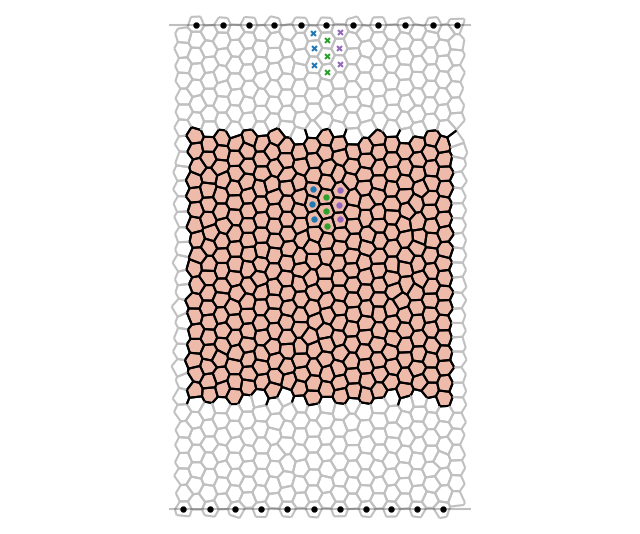

In [ ]:
# add line to visualize the slip boundary

fig = plt.figure(figsize=(8,8)) # 8,8

t = 1

s = 12.5

x = 1
for key in active[1]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:blue", s=s, zorder=10)
for key in active[2]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:green", s=s, zorder=10)
for key in active[3]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:purple", s=s, zorder=10)

for key in passive[1]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:blue", s=s, zorder=10, marker="x")
for key in passive[2]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:green", s=s, zorder=10, marker="x")
for key in passive[3]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:purple", s=s, zorder=10, marker="x")

    
meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
if bdry_lst:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/germ_band_cells_0min.pdf")

(-20.5, 20.5, -17.0, 17.0)

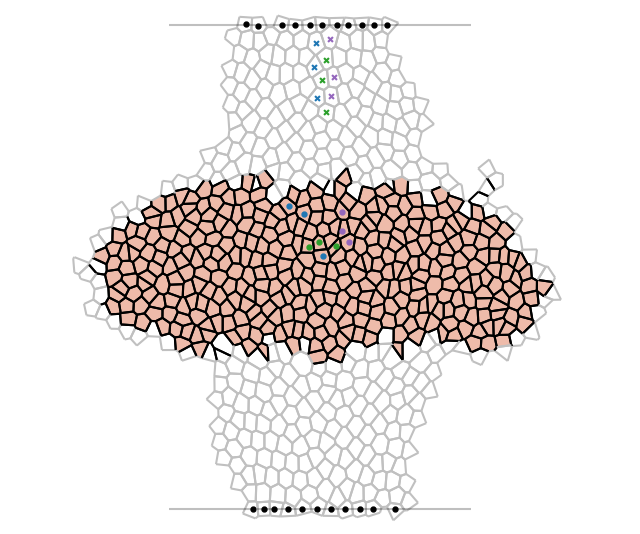

In [ ]:
# add line to visualize the slip boundary

fig = plt.figure(figsize=(8,8))

t = 240

s = 12.5

x = 1
for key in active[1]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:blue", s=s, zorder=10)
for key in active[2]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:green", s=s, zorder=10)
for key in active[3]:
    plt.scatter(*meshes_loaded[t].vertices[key+x].get_centroid(), c="tab:purple", s=s, zorder=10)

for key in passive[1]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:blue", s=s, zorder=10, marker="x")
for key in passive[2]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:green", s=s, zorder=10, marker="x")
for key in passive[3]:
    plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="tab:purple", s=s, zorder=10, marker="x")

    
meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
if bdry_lst:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        plt.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/germ_band_cells_30min.pdf")

(-20.5, 20.5, -17.0, 17.0)

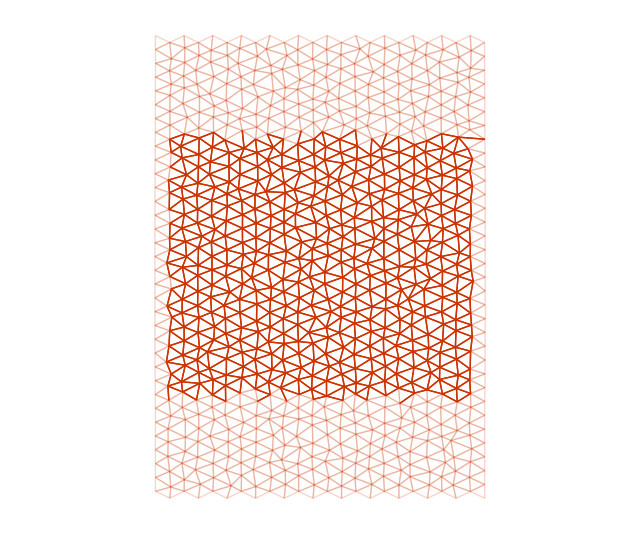

In [ ]:
fig = plt.figure(figsize=(8,8))

t = 1

meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
#plt.savefig(f"{plot_dir}/germ_band_tri_0min.pdf")

(-20.5, 20.5, -17.0, 17.0)

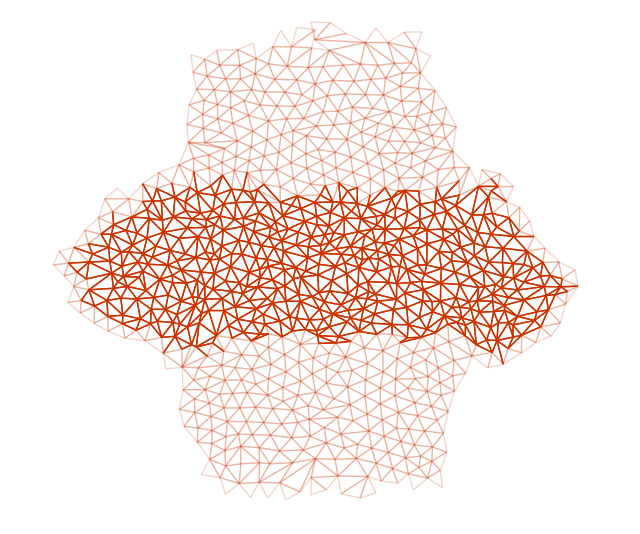

In [ ]:
# add line to visualize the slip boundary

fig = plt.figure(figsize=(8,8))

t = 240

meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
#plt.savefig(f"{plot_dir}/germ_band_tri_30min.pdf")

In [ ]:
trajectories = [[val.get_centroid() for key, val in mesh.vertices.items()
                if (not meshes_loaded[0].vertices[key].is_bdry())] for mesh in meshes_loaded[1:]]

trajectories = np.stack(trajectories).transpose((1,0,2))

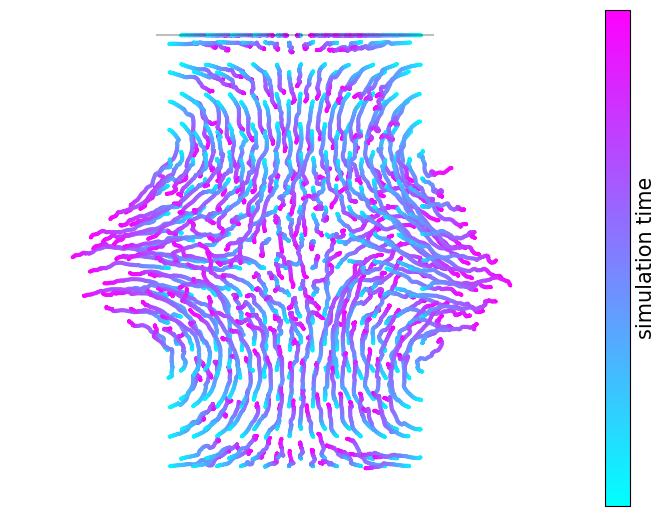

In [ ]:
fig = plt.figure(figsize=(8,8))

t = np.arange(trajectories.shape[1])

stop = -1

for traj in trajectories[::2]:
    plt.scatter(*ndimage.gaussian_filter1d(traj[:stop].T, axis=1, sigma=2), s=2, c=t[:stop], cmap="cool")
    drs.colorline(*ndimage.gaussian_filter1d(traj[:stop].T, axis=1, sigma=2), cmap="cool")

cb = plt.colorbar(fraction=0.04, pad=0.04)
cb.set_ticks([])
cb.set_label(label='simulation time', fontsize=15)

#meshes[stop].cellplot(alpha=.2)

plt.axis("off")

plt.hlines((bdry_y,), (-10, ), (10,), color="k", alpha=0.25)

plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.gca().set_aspect("equal", adjustable="box")

plt.savefig(f"{plot_dir}/germ_band_extension_trajectories.pdf")

## Rendering the frames for the movie

In [ ]:
s = 12.5
lw = 2 
colors = ["tab:blue", "tab:green", "tab:purple"]

In [ ]:
len(meshes_loaded)

250

In [ ]:
for t in tqdm(range(1, 250)):
    fig, (ax1, ax2) = plt.subplots(figsize=(10.1, 5), ncols=2)

    for keys, color in zip(np.array(active)[1:].T, colors):
        for key in keys:
            ax1.scatter(*meshes_loaded[t].vertices[key+1].get_centroid(), c=color, s=s, zorder=10)
    for keys, color in zip(passive[1:], colors):
        for key in keys:
            ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c=color, s=s, zorder=10, marker="x")

    bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
    ax1.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)

    meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors, ax=ax1, lw=1)
    meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri, ax=ax2)


    for ax in (ax1, ax2):
        ax.set_aspect("equal", adjustable="box");
        ax.set_xlim([-2*bdry_x-.5, 2*bdry_x+.5])
        ax.set_ylim([-bdry_y-1, bdry_y+1])
        ax.axis("off")

    ax1.text(1.1, -.1, f"Time: {np.round(t*0.005*25).astype(int)} min", ha="right", fontsize=16,
             transform=ax1.transAxes)

    plt.subplots_adjust(wspace=-0.1)

    plt.savefig(f"{plot_dir}/movie_frames/{str(t).zfill(3)}.png", dpi=150, bbox_inches="tight")
    plt.close()

  0%|          | 0/249 [00:00<?, ?it/s]

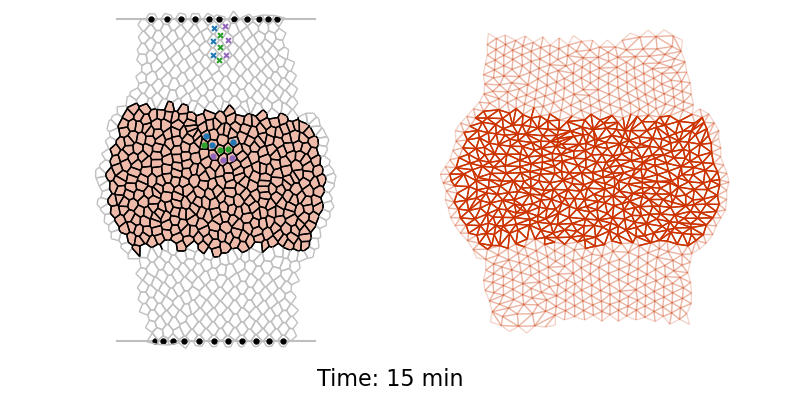

In [ ]:
t = 120

fig, (ax1, ax2) = plt.subplots(figsize=(10.1, 5), ncols=2)

for keys, color in zip(np.array(active)[1:].T, colors):
    for key in keys:
        ax1.scatter(*meshes_loaded[t].vertices[key+1].get_centroid(), c=color, s=s, zorder=10)
for keys, color in zip(passive[1:], colors):
    for key in keys:
        ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c=color, s=s, zorder=10, marker="x")

bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
ax1.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in bdry_lst:
    ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)

meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors, ax=ax1, lw=1)
meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri, ax=ax2)

for ax in (ax1, ax2):
    ax.set_aspect("equal", adjustable="box");
    ax.set_xlim([-2*bdry_x-.5, 2*bdry_x+.5])
    ax.set_ylim([-bdry_y-1, bdry_y+1])
    ax.axis("off")

ax1.text(1.1, -.1, f"Time: {np.round(t*0.005*25).astype(int)} min", ha="right", fontsize=16,
         transform=ax1.transAxes)

plt.subplots_adjust(wspace=-0.1)
#plt.tight_layout()
#plt.savefig(f"{plot_dir}/{str(t).zfill(3)}.png", dpi=150, bbox_inches="tight")


In [ ]:
plot_dir

'/home/fbrauns/Nikolas/code/CE_simulation/plots/v2/fig_7_germ_band'

### WT lenght and width / aspect ratio

In [ ]:
def get_tissue_extension(meshes, sigma=2, log=True, exclude=None):
    exclude = [] if exclude is None else exclude
    centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)
                          ] for mesh in meshes[1:]])

    delta = np.quantile(centroids, axis=1, q=.9)-np.quantile(centroids, axis=1, q=.1,)
    delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)
    delta_smooth /= delta_smooth[0]
    if log:
        delta_log = np.log(delta_smooth)
        return delta_log
    return delta_smooth

In [ ]:
base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band'

extensions_WT = []
for j in [1, 2, 3]:
    save_dir = f'{base_dir}/germ_band_new_post_T1_WT_new_passive/w_passive_7_randomSeed_{j}'
    meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh') for i in range(0, 250, 5)]
    extensions_WT.append(get_tissue_extension(meshes, sigma=2, exclude=property_dict_loaded['passive_cells']))


In [ ]:
time_all = np.arange(0, 250, 5) * 25 * 0.005
time_all.shape

(50,)

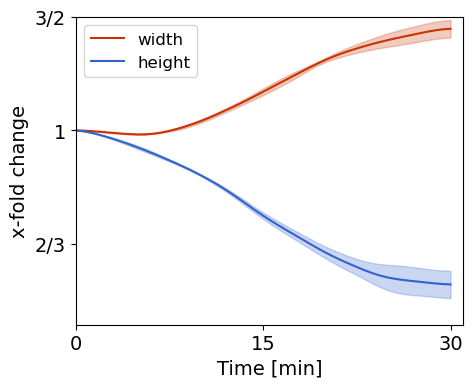

In [ ]:
fig = plt.figure(figsize=(5,4))


plt.plot(time_all[:-1], np.mean(extensions_WT, axis=0)[:,0], color='#ca3300ff', label="width")
plt.fill_between(time_all[:-1], np.mean(extensions_WT, axis=0)[:,0]-np.std(extensions_WT, axis=0)[:,0],
                 np.mean(extensions_WT, axis=0)[:,0]+np.std(extensions_WT, axis=0)[:,0],
                 color='#ca3300ff', alpha=0.25)
plt.plot(time_all[:-1], np.mean(extensions_WT, axis=0)[:,1], color='#3163ceff', label="height")
plt.fill_between(time_all[:-1], np.mean(extensions_WT, axis=0)[:,1]-np.std(extensions_WT, axis=0)[:,1],
                 np.mean(extensions_WT, axis=0)[:,1]+np.std(extensions_WT, axis=0)[:,1],
                 color='#3163ceff', alpha=0.25)

plt.yticks([np.log(2/3), 0, np.log(3/2)], ["2/3", 1, "3/2"], fontsize=14);
plt.ylim([np.log(1/2), np.log(3/2)])
plt.xticks([0, 15, 30], fontsize=14)
plt.xlim([0, 31])

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('x-fold change', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.savefig(f"{plot_dir}/WT_extension_width_height.pdf")

In [ ]:
aspects_WT = [np.sqrt(np.exp(x[:,0])/np.exp(x[:,1])) for x in extensions_WT]

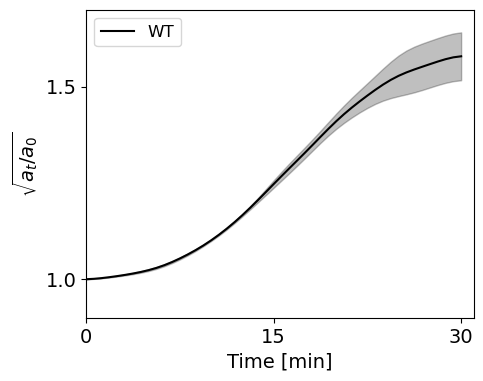

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(time_all[:-1], np.mean(aspects_WT, axis=0), color='k', label="WT")
plt.fill_between(time_all[:-1], np.mean(aspects_WT, axis=0)-np.std(aspects_WT, axis=0),
                 np.mean(aspects_WT, axis=0)+np.std(aspects_WT, axis=0),
                 color='k', alpha=0.25)

plt.yticks([1, 1.5], fontsize=14);
plt.ylim([0.9, 1.7])
plt.xticks([0, 15, 30], fontsize=14)
plt.xlim([0, 31])

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'$\sqrt{a_t/a_0}$', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.savefig(f"{plot_dir}/WT_extension_aspect.pdf")

#plt.savefig(f"{plot_dir}/mutants_extension_aspect_with_error_bar.pdf")

In [ ]:
180*

##  Same plots for TollRM9 and no rigidity

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2/fig_8_mutants"

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

#base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_TollRM9_new_passive'
#save_dir = f'{base_dir}/w_passive_0.5_randomSeed_1' # 1 ok

base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_TollRM9_new_passive_long'
save_dir = f'{base_dir}/w_passive_0.5_randomSeed_1' # 1 is longest

t_final = 180 #180 #125

load_mesh = lambda i: iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh')
meshes_tollRM9 = Parallel(n_jobs=48)(delayed(load_mesh)(i) for i in range(0, t_final, 1))

In [ ]:
with open(f"{save_dir}/property_dict.pickle", "rb") as f:
    property_dict_tollrm9 = pickle.load(f)

with open(f"{save_dir}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_edges_tollrm9 = pickle.load(f)


In [ ]:
edge_colors_tollrm9 = {key: "silver" for key in property_dict_tollrm9['passive_edges']}

edge_colors_tri_tollrm9 = {key: np.array([0.8, 0.2, 0, .2]) if key in property_dict_tollrm9['passive_edges']
                   or any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                   for key, he in meshes_tollRM9[0].hes.items()}

cell_colors_tollrm9 = {key: "#eebbaaff" for key in meshes_tollRM9[0].vertices.keys()
                    if not key in property_dict_tollrm9['passive_cells']}


In [ ]:
time_tollRM9 = np.arange(len(meshes_tollRM9)) * 0.005 * 25

In [ ]:
active = [[351, 352, 353], [384, 385, 386], [419, 420, 421], [452, 453, 454]]
passive = [[342, 343, 344], [375, 376, 377], [410, 411, 412], [443, 444, 445]]

In [ ]:
0.005*25*120

15.0

(-20.5, 20.5, -17.0, 17.0)

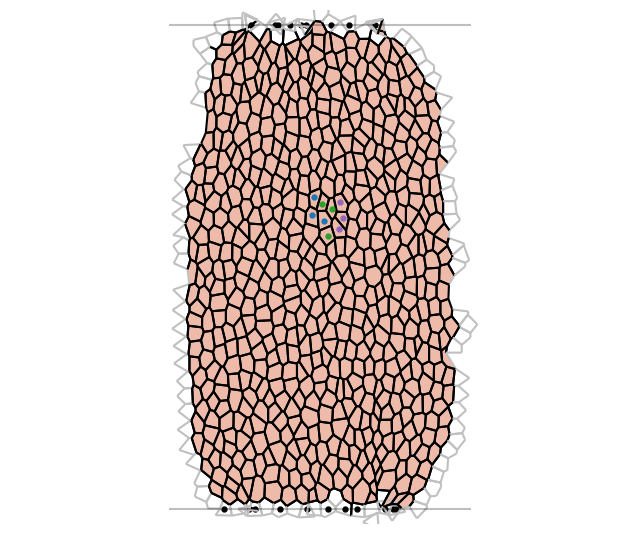

In [ ]:
fig = plt.figure(figsize=(8,8)) # 8,8

t = 120 # 120

s = 12.5

x = 1
for key in active[1]:
    plt.scatter(*meshes_tollRM9[t].vertices[key+x].get_centroid(), c="tab:blue", s=s, zorder=10)
for key in active[2]:
    plt.scatter(*meshes_tollRM9[t].vertices[key+x].get_centroid(), c="tab:green", s=s, zorder=10)
for key in active[3]:
    plt.scatter(*meshes_tollRM9[t].vertices[key+x].get_centroid(), c="tab:purple", s=s, zorder=10)

#for key in passive[1]:
#    plt.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="tab:blue", s=s, zorder=10, marker="x")
#for key in passive[2]:
#    plt.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="tab:green", s=s, zorder=10, marker="x")
#for key in passive[3]:
#    plt.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="tab:purple", s=s, zorder=10, marker="x")

    
meshes_tollRM9[t].cellplot(edge_colors=edge_colors_tollrm9, cell_colors=cell_colors_tollrm9)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict_tollrm9['bdry_x'], property_dict_tollrm9['bdry_y'])
if bdry_lst:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        plt.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="k", s=s)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/tollrm9_cells_20min.pdf")

(-20.5, 20.5, -17.0, 17.0)

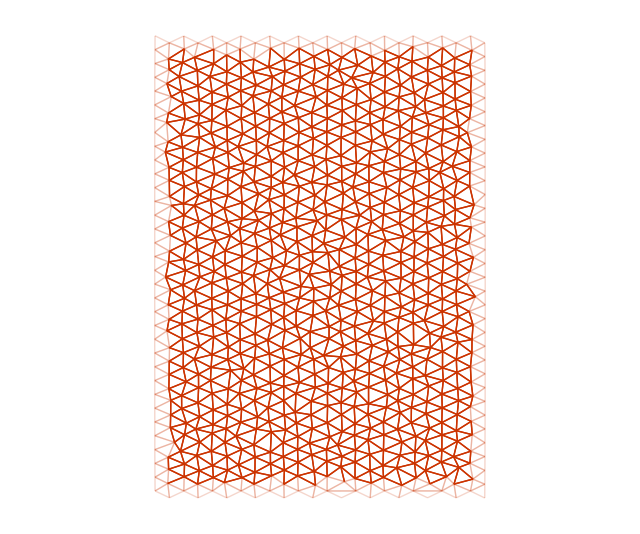

In [ ]:
fig = plt.figure(figsize=(8,8))

t = 1

meshes_tollRM9[t].triplot_color(edge_colors=edge_colors_tri_tollrm9)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
#plt.savefig(f"{plot_dir}/tollrm9_tris_0min.pdf")

## Elastic energy

In [ ]:
energies = [{key: val for key, val in msh.get_shape_energies(mod_bulk=1, mod_shear=1).items()
             if val is not None} for msh in meshes_tollRM9]

In [ ]:
energies_WT = [{key: val for key, val in msh.get_shape_energies(mod_bulk=1, mod_shear=1).items()
              if val is not None} for msh in meshes_loaded]

In [ ]:
energy_arr_tollrm9 = np.stack([[val for key, val in x.items() if not key in property_dict_loaded["passive_cells"]]
                               for x in energies])

In [ ]:
energy_arr_WT = np.stack([[val for key, val in x.items() if not key in property_dict_loaded["passive_cells"]]
                          for x in energies_WT])

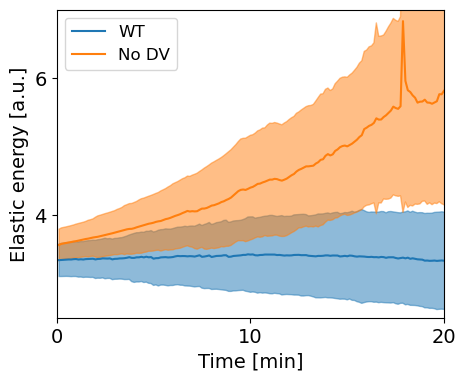

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(time[1:], energy_arr_WT.mean(axis=-1)[1:], label="WT")
plt.fill_between(time[1:], energy_arr_WT.mean(axis=-1)[1:]-energy_arr_WT.std(axis=-1)[1:],
                 energy_arr_WT.mean(axis=-1)[1:]+energy_arr_WT.std(axis=-1)[1:], alpha=0.5, color="tab:blue")

plt.plot(time_tollRM9[1:], energy_arr_tollrm9.mean(axis=-1)[1:], label="No DV")
plt.fill_between(time_tollRM9[1:], energy_arr_tollrm9.mean(axis=-1)[1:]-energy_arr_tollrm9.std(axis=-1)[1:],
                 energy_arr_tollrm9.mean(axis=-1)[1:]+energy_arr_tollrm9.std(axis=-1)[1:],
                 alpha=0.5, color="tab:orange")

plt.yticks([2, 4, 6], fontsize=14);
plt.ylim([2.5, 7])

plt.xticks([0, 10, 20], fontsize=14)
plt.xlim([0, 20])

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'Elastic energy [a.u.]', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.savefig(f"{plot_dir}/tollrm9_energy.pdf")

### Analsyis of T1s 

In [ ]:
length_dicts_WT = [x.get_primal_edge_lens(include_duplicates=True) for x in meshes_loaded]
length_dicts_tollRM9 = [x.get_primal_edge_lens(include_duplicates=True) for x in meshes_tollRM9]

In [ ]:
len(length_dicts_tollRM9)

180

In [ ]:
125/2

62.5

In [ ]:
# collect all junction lengths

# align on T1 transitions using the saved ids of T1s during simulation.

lengths_stacked = []

dt = 80
t0 = 80
for i in range(t0, 99):
    for e in last_flipped_edges_tollrm9[i]:
        if not e in property_dict_tollrm9['passive_edges']:
            length = np.stack([x[e] for x in length_dicts_tollRM9])
            lengths_stacked.append(length[i-dt:i+dt])
            
lengths_stacked = np.stack(lengths_stacked)

In [ ]:
lengths_stacked_WT = []

for i in range(t0, 99):
    for e in last_flipped_edges[i]:
        if not e in property_dict_loaded['passive_edges']:
            length = np.stack([x[e] for x in length_dicts_WT])
            lengths_stacked_WT.append(length[i-dt:i+dt])
            
lengths_stacked_WT = np.stack(lengths_stacked_WT)

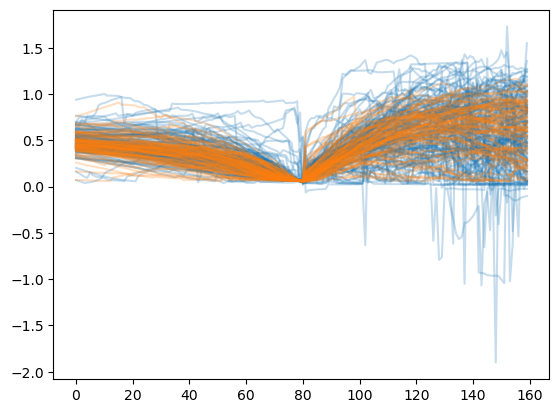

In [ ]:
for x in lengths_stacked:
    plt.plot(x, color="tab:blue", alpha=0.25)
    
for x in lengths_stacked_WT:
    plt.plot(x, color="tab:orange", alpha=0.25)

In [ ]:
# T1 can also be reconstructed easily by looking at edges which change vertex ids at any given time

#flipped = [[key for key in meshes[t].hes.keys() 
#            if [v._vid for v in meshes[t].hes[key].vertices] != [v._vid for v in meshes[t+1].hes[key].vertices]]
#            for t in range(0, 70)] + []


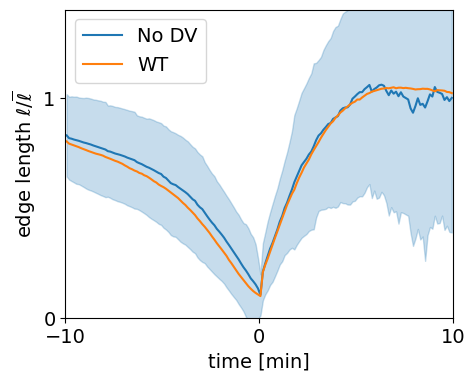

In [ ]:
fig = plt.figure(figsize=(5,4))

length_scale = np.array([np.mean(list(x.values())) for x in length_dicts_tollRM9])[t0-dt:t0+dt]
length_scale_WT = np.array([np.mean(list(x.values())) for x in length_dicts_WT])[t0-dt:t0+dt]

time_T1 = np.arange(lengths_stacked.shape[1]) * 0.005 * 25
time_T1 -= time_T1.mean()

mean = (lengths_stacked.mean(axis=0)) / length_scale
#mean = np.median(lengths_stacked, axis=0) * length_scale
std = lengths_stacked.std(axis=0) / length_scale

mean_WT = (lengths_stacked_WT.mean(axis=0)) / length_scale_WT
std_WT = lengths_stacked_WT.std(axis=0) / length_scale_WT

plt.plot(time_T1, mean, color='tab:blue', label='No DV')
plt.fill_between(time_T1, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.plot(time_T1, mean_WT, color='tab:orange', label='WT')

plt.xlim([-8, 8])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 1], fontsize=14)
plt.ylim([0, 1.4])

plt.xlabel('time [min]', fontsize=14)
plt.ylabel(r'edge length $\ell/\overline{\ell}$', fontsize=14)
plt.legend(fontsize=14, loc="upper left")

plt.savefig(f"{plot_dir}/tollrm9_junction_length.pdf")

In [ ]:
## we can also look at the orientations of collapsing/extending junctions

collapsed = []
new = []

dt = 20

for i in range(30, 100):
    for e in last_flipped_edges_tollrm9[i]:
        if not meshes_tollRM9[0].hes[e].is_bdry():
            he = meshes_tollRM9[i-dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            collapsed.append(np.arctan2(*vector[::-1]))
            
            he = meshes_tollRM9[i+dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            new.append(np.arctan2(*vector[::-1]))
            
collapsed = np.stack(collapsed)
new = np.stack(new)

# if desired, save
#np.savetxt("plots/for_figure_v2/collapsing_angle_control.txt", collapsed)
#np.savetxt("plots/for_figure_v2/extending_angle_control.txt", new)

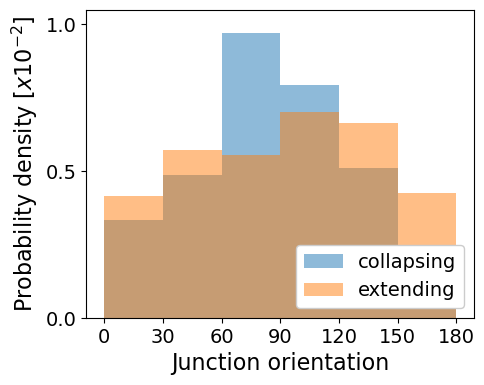

In [ ]:
fig = plt.figure(figsize=(5,4))

bins = np.arange(0, 181, 30)

plt.hist(collapsed*(180/np.pi), bins=bins, alpha=.5, label="collapsing", density=True)
plt.hist(new*(180/np.pi), bins=bins, alpha=.5, label="extending", density=True)

plt.xticks(np.arange(0, 181, 30), fontsize=14)
plt.yticks(np.linspace(0, 0.01, 3), 1e2*np.linspace(0, 0.01, 3), fontsize=14)

plt.xlabel("Junction orientation", fontsize=16)
plt.ylabel(r"Probability density [$x10^{-2}$]", fontsize=16)

plt.legend(fontsize=14, loc="lower right", facecolor='white', framealpha=1)
plt.ylim([0, 1.05*1e-2])

plt.savefig(f"{plot_dir}/tollrm9_junction_orientation.pdf")

In [ ]:
collapsed = []
new = []

dt = 20

for i in range(30, 100):
    for e in last_flipped_edges[i]:
        if not meshes_loaded[0].hes[e].is_bdry():
            he = meshes_loaded[i-dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            collapsed.append(np.arctan2(*vector[::-1]))
            
            he = meshes_loaded[i+dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            new.append(np.arctan2(*vector[::-1]))
            
collapsed = np.stack(collapsed)
new = np.stack(new)

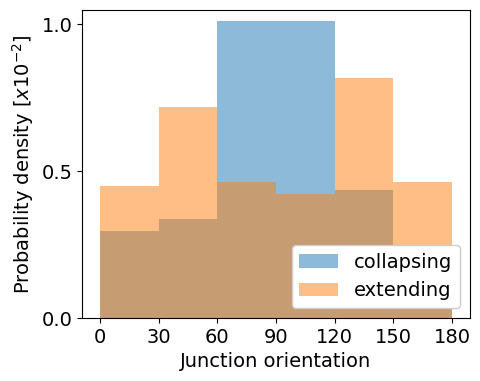

In [ ]:
## for WT

fig = plt.figure(figsize=(5,4))

bins = np.arange(0, 181, 30)

plt.hist(collapsed*(180/np.pi), bins=bins, alpha=.5, label="collapsing", density=True)
plt.hist(new*(180/np.pi), bins=bins, alpha=.5, label="extending", density=True)

plt.xticks(np.arange(0, 181, 30), fontsize=14)
plt.yticks(np.linspace(0, 0.01, 3), 1e2*np.linspace(0, 0.01, 3), fontsize=14)

plt.xlabel("Junction orientation", fontsize=14)
plt.ylabel(r"Probability density [$x10^{-2}$]", fontsize=14)

plt.legend(fontsize=14, loc="lower right", facecolor='white', framealpha=1)
plt.ylim([0, 1.05*1e-2])
plt.savefig(f"{plot_dir}/WT_junction_orientation.pdf")

In [ ]:
## cell elongation

In [ ]:
t_final = 160

shapes_tollrm9 = np.stack([v.get_shape_tensor() for key, v in meshes_tollRM9[t_final].vertices.items()
                  if not key in property_dict_tollrm9["passive_cells"] and not v.is_bdry()])

shapes_WT = np.stack([v.get_shape_tensor() for key, v in meshes_loaded[t_final].vertices.items()
             if not key in property_dict_loaded["passive_cells"] and not v.is_bdry()])

shapes_shear = np.stack([v.get_shape_tensor() for key, v in meshes_shear[t_final].vertices.items()
                  if not key in property_dict_shear["passive_cells"] and not v.is_bdry()])

In [ ]:
aniso_tollrm9 = (shapes_tollrm9[:,1,1]-shapes_tollrm9[:,0,0])/(shapes_tollrm9[:,1,1]+shapes_tollrm9[:,0,0])
aniso_shear = (shapes_shear[:,1,1]-shapes_shear[:,0,0])/(shapes_shear[:,1,1]+shapes_shear[:,0,0])

aniso_WT = (shapes_WT[:,1,1]-shapes_WT[:,0,0])/(shapes_WT[:,1,1]+shapes_WT[:,0,0])

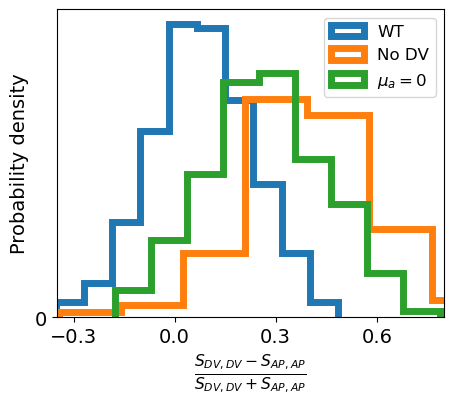

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.hist(aniso_WT, bins=10, alpha=1, density=True, label="WT",
                  histtype='step', fill=False, ec="tab:blue", lw=5);
plt.hist(aniso_tollrm9, bins=10, alpha=1, density=True, label="No DV",
                  histtype='step', fill=False, ec="tab:orange", lw=5);
plt.hist(aniso_shear, bins=10, density=True, label=r"$\mu_a=0$",
         histtype='step', fill=False, ec="tab:green", lw=5);


plt.xlabel(r"$\frac{S_{DV,DV}-S_{AP,AP}}{S_{DV,DV}+S_{AP,AP}}$", fontsize=16)
plt.ylabel("Probability density",fontsize=14);

plt.legend(fontsize=12)

plt.xticks([-.3, 0, .3, .6], fontsize=14)
plt.xlim([-0.35, 0.8])
plt.yticks([0], fontsize=14)

plt.savefig(f"{plot_dir}/cell_elongation_WT_shear_TollRM9.pdf")

### Analysis of shear modulus mutants

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files

#base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_shear_new_passive' # shear_modulus
#save_dir = f'{base_dir}/shearActive_0.01_shearPassive_1_rep_3'


base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_shear_new_passive_long'
save_dir = f'{base_dir}/shearActive_0.01_shearPassive_1_rep_1'


load_mesh = lambda i: iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh')
meshes_shear = Parallel(n_jobs=48)(delayed(load_mesh)(i) for i in range(0, 180, 1)) # 125

In [ ]:
with open(f"{save_dir}/property_dict.pickle", "rb") as f:
    property_dict_shear = pickle.load(f)

with open(f"{save_dir}/last_flipped_edges.pickle", "rb") as f:
    last_flipped_edges_shear = pickle.load(f)


In [ ]:
edge_colors_shear = {key: "silver" for key in property_dict_shear['passive_edges']}

edge_colors_tri_shear = {key: np.array([0.8, 0.2, 0, .2]) if key in property_dict_shear['passive_edges']
                   or any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                   for key, he in meshes_shear[0].hes.items()}

cell_colors_shear = {key: "#eebbaaff" for key in meshes_shear[0].vertices.keys()
                    if not key in property_dict_shear['passive_cells']}


In [ ]:
time_shear = np.arange(len(meshes_shear)) * 0.005 * 25

In [ ]:
active = [[351, 352, 353], [384, 385, 386], [419, 420, 421], [452, 453, 454]]
passive = [[342, 343, 344], [375, 376, 377], [410, 411, 412], [443, 444, 445]]

(-20.5, 20.5, -17.0, 17.0)

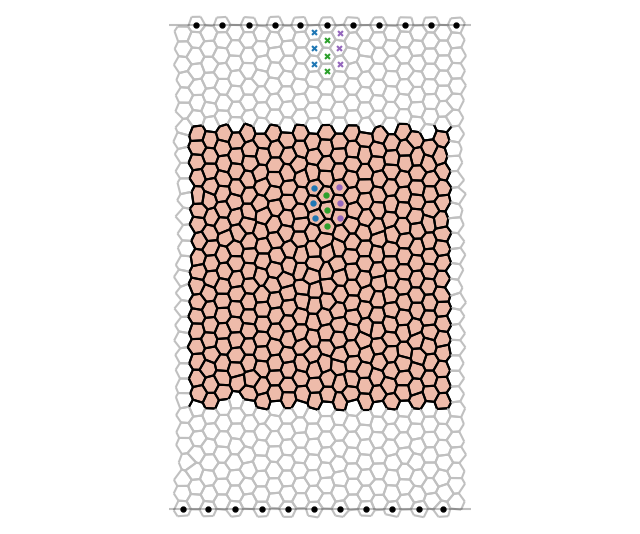

In [ ]:
fig = plt.figure(figsize=(8,8)) # 8,8

t = 1 # 120

s = 12.5

x = 1
for key in active[1]:
    plt.scatter(*meshes_shear[t].vertices[key+x].get_centroid(), c="tab:blue", s=s, zorder=10)
for key in active[2]:
    plt.scatter(*meshes_shear[t].vertices[key+x].get_centroid(), c="tab:green", s=s, zorder=10)
for key in active[3]:
    plt.scatter(*meshes_shear[t].vertices[key+x].get_centroid(), c="tab:purple", s=s, zorder=10)

for key in passive[1]:
    plt.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="tab:blue", s=s, zorder=10, marker="x")
for key in passive[2]:
    plt.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="tab:green", s=s, zorder=10, marker="x")
for key in passive[3]:
    plt.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="tab:purple", s=s, zorder=10, marker="x")

    
meshes_shear[t].cellplot(edge_colors=edge_colors_shear, cell_colors=cell_colors_shear)

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict_shear['bdry_x'], property_dict_shear['bdry_y'])
if bdry_lst:
    plt.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        plt.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="k", s=s)


plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")

#plt.savefig(f"{plot_dir}/shear_cells_0min.pdf")

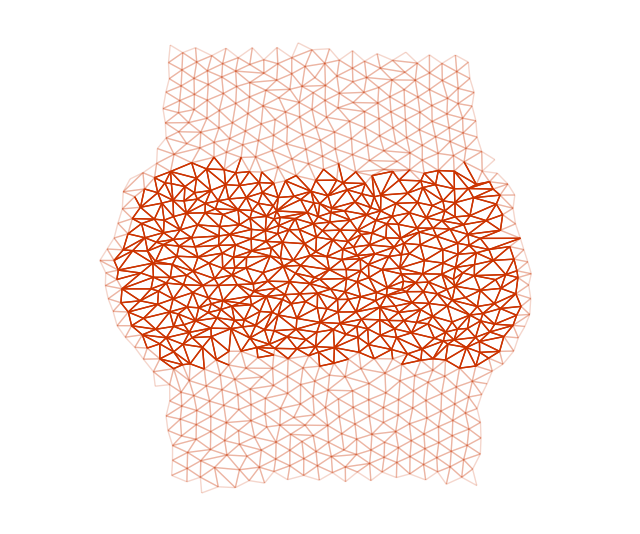

In [ ]:
fig = plt.figure(figsize=(8,8))

t = 120

meshes_shear[t].triplot_color(edge_colors=edge_colors_tri_shear)

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-2*bdry_x-.5, 2*bdry_x+.5])
plt.ylim([-bdry_y-1, bdry_y+1])

plt.axis("off")
plt.savefig(f"{plot_dir}/shear_tris_15min.pdf")

In [ ]:
#base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/shear_modulus'
base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band/germ_band_new_post_T1_shear_new_passive_long'

t_final = 160

def get_extension(rel_shear):
    extensions = []
    for j in [1, 2, 3]:
        save_dir = f'{base_dir}/shearActive_{rel_shear}_shearPassive_1_rep_{j}'
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh')
                  for i in range(0, t_final, 5)]
        extensions.append(get_tissue_extension(meshes, sigma=2, exclude=property_dict_shear['passive_cells']))
    return np.mean(extensions, axis=0)

In [ ]:
160*0.005*25

20.0

In [ ]:
rel_shears = [0.01, 0.1, 0.5, 1, 2, 4, 8]
extensions = Parallel(n_jobs=6)(delayed(get_extension)(rel_shear) for rel_shear in rel_shears)

extensions = np.array(extensions)
rel_shears = np.array(rel_shears)

In [ ]:
final_ext = np.sqrt(np.exp(extensions[:,-1,0])/np.exp(extensions[:,-1,1]))

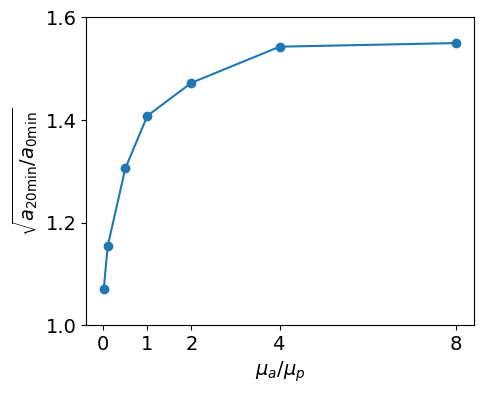

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(rel_shears, final_ext, marker='o')

plt.yticks([1.0, 1.2, 1.4, 1.6,], fontsize=14);
plt.xticks([0, 1, 2, 4, 8], fontsize=14)
plt.xlabel(r'$\mu_a / \mu_p$',fontsize=14)
plt.ylabel(r'$\sqrt{a_{20\mathrm{min}}/a_{0\mathrm{min}}}$', fontsize=14)

plt.savefig(f"{plot_dir}/shear_modulus_ratio_aspect.pdf")

### Rendering the movie for the mutants

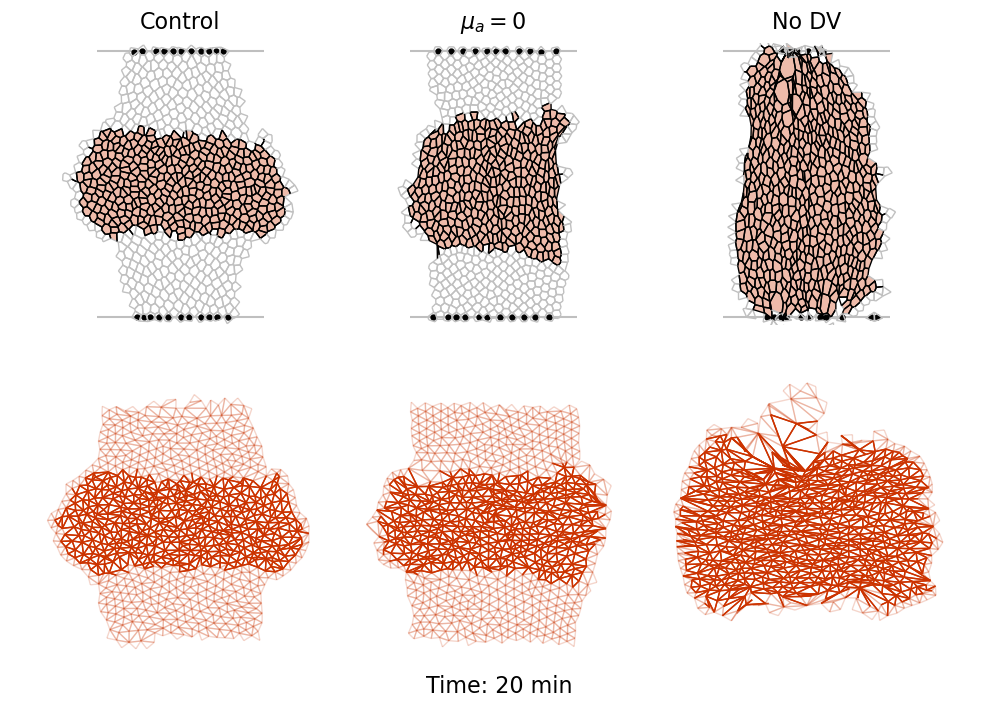

In [ ]:
t = 160

s = 12.5
lw = 1

fig, ((ax1, ax2, ax3), (bx1, bx2, bx3)) = plt.subplots(figsize=(16.154, 8.077), nrows=2, ncols=3)

## WT

bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
ax1.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in bdry_lst:
    ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)

meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors, ax=ax1, lw=lw)
meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri, ax=bx1)


## no shear

bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
ax2.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in bdry_lst:
    ax2.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="k", s=s)

meshes_shear[t].cellplot(edge_colors=edge_colors_shear, cell_colors=cell_colors_shear, ax=ax2, lw=lw)
meshes_shear[t].triplot_color(edge_colors=edge_colors_tri_shear, ax=bx2)


## Toll RM9

bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
ax3.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
for key in bdry_lst:
    ax3.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="k", s=s)

meshes_tollRM9[t].cellplot(edge_colors=edge_colors_tollrm9, cell_colors=cell_colors_tollrm9, ax=ax3, lw=lw)
meshes_tollRM9[t].triplot_color(edge_colors=edge_colors_tri_tollrm9, ax=bx3)


for ax in (ax1, ax2, ax3, bx1, bx2, bx3):
    ax.set_aspect("equal", adjustable="box");
    ax.set_xlim([-2*bdry_x-.5, 2*bdry_x+.5])
    ax.set_ylim([-bdry_y-1, bdry_y+1])
    ax.axis("off")

bx1.text(1.65, -.1, f"Time: {np.round(t*0.005*25).astype(int)} min", ha="right", fontsize=16,
         transform=bx1.transAxes)

ax1.text(0.5, 1.05, f"Control", ha="center", fontsize=16, transform=ax1.transAxes)
ax2.text(0.5, 1.05, r"$\mu_a=0$", ha="center", fontsize=16, transform=ax2.transAxes)
ax3.text(0.5, 1.05, f"No DV", ha="center", fontsize=16, transform=ax3.transAxes)


plt.subplots_adjust(wspace=-0.5)
#plt.tight_layout()
plt.savefig(f"{plot_dir}/{str(t).zfill(3)}.png", dpi=150, bbox_inches="tight")

In [ ]:
for t in tqdm(range(1, 161)):
    fig, ((ax1, ax2, ax3), (bx1, bx2, bx3)) = plt.subplots(figsize=(16.154, 8.077), nrows=2, ncols=3)

    ## WT

    bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
    ax1.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        ax1.scatter(*meshes_loaded[t].vertices[key].get_centroid(), c="k", s=s)

    meshes_loaded[t].cellplot(edge_colors=edge_colors, cell_colors=cell_colors, ax=ax1, lw=lw)
    meshes_loaded[t].triplot_color(edge_colors=edge_colors_tri, ax=bx1)


    ## no shear

    bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
    ax2.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        ax2.scatter(*meshes_shear[t].vertices[key].get_centroid(), c="k", s=s)

    meshes_shear[t].cellplot(edge_colors=edge_colors_shear, cell_colors=cell_colors_shear, ax=ax2, lw=lw)
    meshes_shear[t].triplot_color(edge_colors=edge_colors_tri_shear, ax=bx2)


    ## Toll RM9

    bdry_x, bdry_y = (property_dict_loaded['bdry_x'], property_dict_loaded['bdry_y'])
    ax3.hlines((bdry_y, -bdry_y), (-10, -10), (10, 10), color="k", alpha=0.25)
    for key in bdry_lst:
        ax3.scatter(*meshes_tollRM9[t].vertices[key].get_centroid(), c="k", s=s)

    meshes_tollRM9[t].cellplot(edge_colors=edge_colors_tollrm9, cell_colors=cell_colors_tollrm9, ax=ax3, lw=lw)
    meshes_tollRM9[t].triplot_color(edge_colors=edge_colors_tri_tollrm9, ax=bx3)


    for ax in (ax1, ax2, ax3, bx1, bx2, bx3):
        ax.set_aspect("equal", adjustable="box");
        ax.set_xlim([-2*bdry_x-.5, 2*bdry_x+.5])
        ax.set_ylim([-bdry_y-1, bdry_y+1])
        ax.axis("off")

    bx1.text(1.65, -.1, f"Time: {np.round(t*0.005*25).astype(int)} min", ha="right", fontsize=16,
             transform=bx1.transAxes)
    
    ax1.text(0.5, 1.05, f"Control", ha="center", fontsize=16, transform=ax1.transAxes)
    ax2.text(0.5, 1.05, r"$\mu_a=0$", ha="center", fontsize=16, transform=ax2.transAxes)
    ax3.text(0.5, 1.05, f"No DV", ha="center", fontsize=16, transform=ax3.transAxes)

    plt.subplots_adjust(wspace=-0.5)
    #plt.tight_layout()
    plt.savefig(f"{plot_dir}/movie_frames/{str(t).zfill(3)}.png", dpi=150, bbox_inches="tight")
    plt.close()

  0%|          | 0/160 [00:00<?, ?it/s]

### extension of the different conditions

In [ ]:
# remove angle patterning in TollRM9 sims??

In [ ]:
# need imputation

def load_impute(save_dir, reps=(1, 2, 3,), step=5, t_final=200):
    n_meshes = {j: len([x for x in os.listdir(save_dir+str(j)) if "mesh" in x]) for j in reps}
    meshes = {j: [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}{j}/{str(i).zfill(4)}_mesh')
              for i in range(0, min([n_meshes[j], t_final]), step)] for j in reps}
    extensions_dict = {j: get_tissue_extension(meshes[j], sigma=2, exclude=property_dict_loaded['passive_cells'])
                       for j in reps}
    pad_width = int(t_final/step)
    extensions = [np.pad(val, ((0, pad_width-val.shape[0]), (0, 0)), 'constant', constant_values=np.nan)
                  for val in extensions_dict.values()]
    return np.array(extensions)

In [ ]:
base_dir = '/data/Nikolas/GBE_simulation/runs/germ_band'

t_final = 200

save_dir = f'{base_dir}/germ_band_new_post_T1_WT_new_passive/w_passive_7_randomSeed_'
extensions_WT = load_impute(save_dir, step=5, t_final=t_final)

save_dir = f'{base_dir}/germ_band_new_post_T1_TollRM9_new_passive_long/w_passive_0.5_randomSeed_'
extensions_tollRM9 = load_impute(save_dir, step=5, t_final=t_final)

save_dir = f'{base_dir}/germ_band_new_post_T1_shear_new_passive_long/shearActive_0.01_shearPassive_1_rep_'
extensions_shear = load_impute(save_dir, step=5, t_final=t_final)

In [ ]:
time_all = np.arange(0, t_final, 5) * 25 * 0.005
time_all.shape

(40,)

/tmp/ipykernel_319172/296004755.py:4: RuntimeWarning: Mean of empty slice
  plt.plot(time_all, np.nanmean(extensions_WT, axis=0)[:,0], color='#ca3300ff', label="WT")
/home/fbrauns/miniconda/envs/nikolas/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_319172/296004755.py:8: RuntimeWarning: Mean of empty slice
  plt.plot(time_all, np.nanmean(extensions_WT, axis=0)[:,1], color='#3163ceff')
/tmp/ipykernel_319172/296004755.py:13: RuntimeWarning: Mean of empty slice
  plt.plot(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,0], color='#ca3300ff', ls="dashed", label="No DV")
/tmp/ipykernel_319172/296004755.py:14: RuntimeWarning: Mean of empty slice
  plt.fill_between(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,0]-np.nanmax(np.nanstd(extensions_tollRM9, axis=0)[:,0]),
/tmp/ipykernel_319172/296004755.py:15: RuntimeWarning: Mean of empty slice
  n

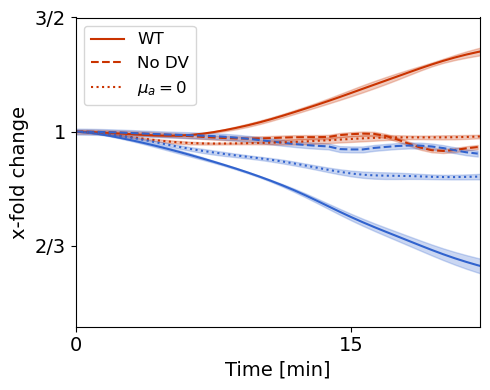

In [ ]:
fig = plt.figure(figsize=(5,4))


plt.plot(time_all, np.nanmean(extensions_WT, axis=0)[:,0], color='#ca3300ff', label="WT")
plt.fill_between(time_all, np.mean(extensions_WT, axis=0)[:,0]-np.nanstd(extensions_WT, axis=0)[:,0],
                 np.mean(extensions_WT, axis=0)[:,0]+np.nanstd(extensions_WT, axis=0)[:,0],
                 color='#ca3300ff', alpha=0.25)
plt.plot(time_all, np.nanmean(extensions_WT, axis=0)[:,1], color='#3163ceff')
plt.fill_between(time_all, np.mean(extensions_WT, axis=0)[:,1]-np.nanstd(extensions_WT, axis=0)[:,1],
                 np.mean(extensions_WT, axis=0)[:,1]+np.nanstd(extensions_WT, axis=0)[:,1],
                 color='#3163ceff', alpha=0.25)

plt.plot(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,0], color='#ca3300ff', ls="dashed", label="No DV")
plt.fill_between(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,0]-np.nanmax(np.nanstd(extensions_tollRM9, axis=0)[:,0]),
                 np.nanmean(extensions_tollRM9, axis=0)[:,0]+np.nanmax(np.nanstd(extensions_tollRM9, axis=0)[:,0]),
                 color='#ca3300ff', alpha=0.25)
plt.plot(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,1], color='#3163ceff', ls="dashed")
plt.fill_between(time_all, np.nanmean(extensions_tollRM9, axis=0)[:,1]-np.nanmax(np.nanstd(extensions_tollRM9, axis=0)[:,1]),
                 np.nanmean(extensions_tollRM9, axis=0)[:,1]+np.nanmax(np.nanstd(extensions_tollRM9, axis=0)[:,1]),
                 color='#3163ceff', alpha=0.25)

plt.plot(time_all, np.nanmean(extensions_shear, axis=0)[:,0], color='#ca3300ff', ls="dotted", label=r"$\mu_a=0$")
plt.fill_between(time_all, np.mean(extensions_shear, axis=0)[:,0]-np.std(extensions_shear, axis=0)[:,0],
                 np.mean(extensions_shear, axis=0)[:,0]+np.nanstd(extensions_shear, axis=0)[:,0],
                 color='#ca3300ff', alpha=0.25)
plt.plot(time_all, np.nanmean(extensions_shear, axis=0)[:,1], color='#3163ceff', ls="dotted")
plt.fill_between(time_all, np.mean(extensions_shear, axis=0)[:,1]-np.nanstd(extensions_shear, axis=0)[:,1],
                 np.mean(extensions_shear, axis=0)[:,1]+np.nanstd(extensions_shear, axis=0)[:,1],
                 color='#3163ceff', alpha=0.25)

plt.yticks([np.log(2/3), 0, np.log(3/2)], ["2/3", 1, "3/2"], fontsize=14);
plt.ylim([np.log(1/2), np.log(3/2)])
plt.xticks([0, 15,], fontsize=14)
plt.xlim([0, 22])

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('x-fold change', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(f"{plot_dir}/mutants_extension_width_height.pdf")

In [ ]:
aspects_WT = [np.sqrt(np.exp(x[:,0])/np.exp(x[:,1])) for x in extensions_WT]
aspects_tollRM9 = [np.sqrt(np.exp(x[:,0])/np.exp(x[:,1])) for x in extensions_tollRM9]
aspects_shear = [np.sqrt(np.exp(x[:,0])/np.exp(x[:,1])) for x in extensions_shear]

In [ ]:
np.nanmax(np.nanstd(aspects_tollRM9, axis=0))

0.008137869453088723

/tmp/ipykernel_319172/4147489486.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(time_all, np.nanmean(aspects_WT, axis=0), color='k', label="WT")
/tmp/ipykernel_319172/4147489486.py:4: RuntimeWarning: Mean of empty slice
  plt.fill_between(time_all, np.nanmean(aspects_WT, axis=0)-np.nanstd(aspects_WT, axis=0),
/home/fbrauns/miniconda/envs/nikolas/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_319172/4147489486.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(aspects_WT, axis=0)+np.nanstd(aspects_WT, axis=0),
/tmp/ipykernel_319172/4147489486.py:8: RuntimeWarning: Mean of empty slice
  plt.plot(time_all, np.nanmean(aspects_tollRM9, axis=0), color='k', label="No DV", ls="dashed")
/tmp/ipykernel_319172/4147489486.py:9: RuntimeWarning: Mean of empty slice
  plt.fill_between(time_all, np.nanmean(aspects_tollRM9, axis=0)-np.nanmax(np.nanstd(a

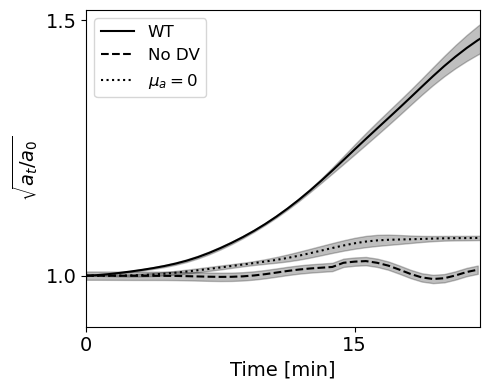

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(time_all, np.nanmean(aspects_WT, axis=0), color='k', label="WT")
plt.fill_between(time_all, np.nanmean(aspects_WT, axis=0)-np.nanstd(aspects_WT, axis=0),
                 np.nanmean(aspects_WT, axis=0)+np.nanstd(aspects_WT, axis=0),
                 color='k', alpha=0.25)

plt.plot(time_all, np.nanmean(aspects_tollRM9, axis=0), color='k', label="No DV", ls="dashed")
plt.fill_between(time_all, np.nanmean(aspects_tollRM9, axis=0)-np.nanmax(np.nanstd(aspects_tollRM9, axis=0)),
                 np.nanmean(aspects_tollRM9, axis=0)+np.nanmax(np.nanstd(aspects_tollRM9, axis=0)),
                 color='k', alpha=0.25)

plt.plot(time_all, np.nanmean(aspects_shear, axis=0), color='k', label=r"$\mu_a=0$", ls="dotted")
plt.fill_between(time_all, np.nanmean(aspects_shear, axis=0)-np.nanstd(aspects_shear, axis=0),
                 np.nanmean(aspects_shear, axis=0)+np.nanstd(aspects_shear, axis=0),
                 color='k', alpha=0.25)

plt.yticks([1, 1.5], fontsize=14);
plt.ylim([0.9, 1.52])
plt.xticks([0, 15,], fontsize=14)
plt.xlim([0, 22])

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'$\sqrt{a_t/a_0}$', fontsize=14)
plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(f"{plot_dir}/mutants_extension_aspect.pdf")

### Energies & areas

These are mainly useful as numeric diagnostics. Energy vs time also has some independent interest.

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energies(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

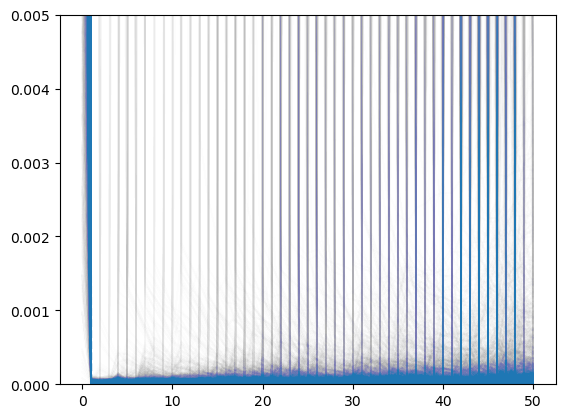

In [ ]:
## time series plot of angle penalties - sin(deviation from triangulation angle)

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.005);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 0.01)

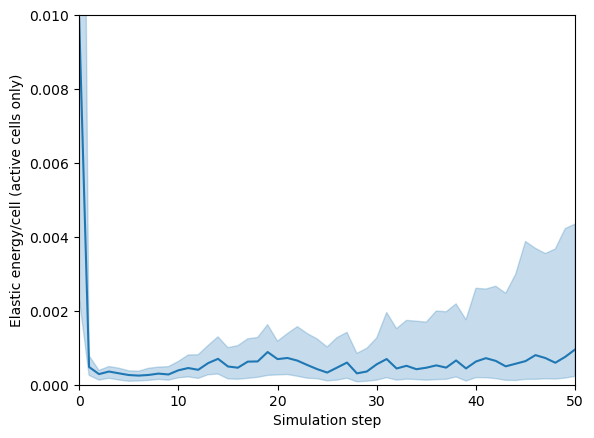

In [ ]:
## time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()
                   if not key in property_dict['passive_cells']])
#plt.plot(e_time.T, color="tab:blue", alpha=.1);
mean = np.median(e_time, axis=0)
err_down, err_up = (np.quantile(e_time, .25, axis=0,), np.quantile(e_time, .75, axis=0,))

plt.plot(mean, color="tab:blue", alpha=1);
plt.fill_between(np.arange(e_time.shape[1]), err_down, err_up,
         color="tab:blue", alpha=.25);

plt.xlabel('Simulation step')
plt.ylabel('Elastic energy/cell (active cells only)')

plt.xlim([0, 50])
plt.ylim([0, 1*1e-2])

#plt.savefig('plots/for_figure_v2/energy_vs_time_quartile_error.pdf', bbox_inches='tight')

<matplotlib.collections.PathCollection>

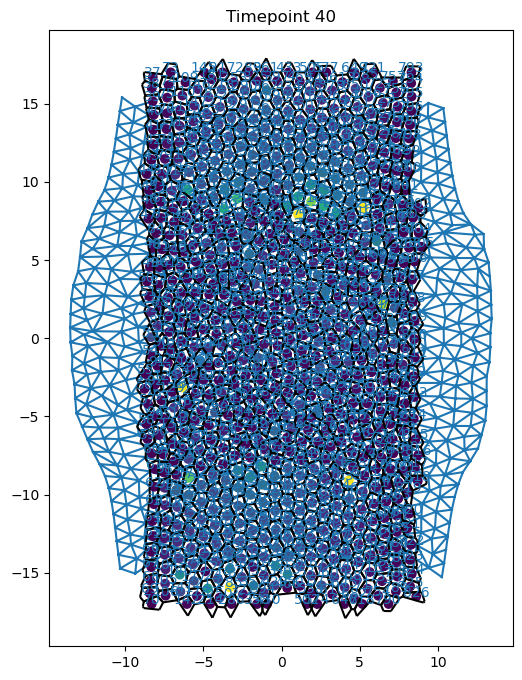

In [ ]:
## spatial plot of shape energies

i = 40

fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(f'Timepoint {i}');

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([meshes[i].vertices[key].get_centroid(), [val]])
                      for key, val in energies[i].items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.05)

(0.0, 1.7320508075688772)

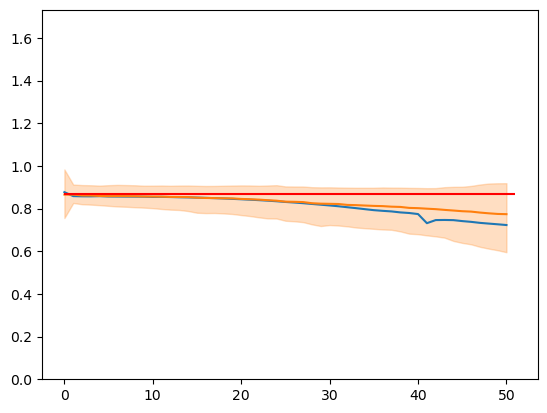

In [ ]:
# create and plot time-series of cell areas

areas = np.stack([[x for x in mesh.get_areas().values() if x is not None] for mesh in meshes])

plt.plot(areas[:, 3]) # an example trajectory
mean = areas.mean(axis=1)
plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(np.sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, np.sqrt(3)])

### Plot small snapshots

In [ ]:
#| notest
def plot_snapshot(i, xlim, ylim):
    plt.cla()
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors={}, cell_colors=cell_colors)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xticks([],[])
    plt.yticks([],[])

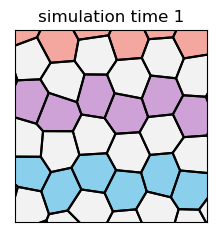

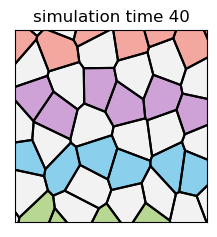

In [ ]:
for i in [1, 40]:
    fig = plt.figure(figsize=(2.5, 2.5))
    plot_snapshot(i, xlim=[-2.5, 2.5], ylim=[-4, 1])
    #plt.savefig(f"plots/for_figure_v3/snapshot_time_{i}.pdf")
    plt.title(f'simulation time {i}')
    plt.show()
